In [33]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [34]:
df = pd.read_csv('affairs.csv')
# 型別確認與基本資訊
print("--- 資料型別檢查 ---")
df.head()

--- 資料型別檢查 ---


,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
0,0,male,37.0,10.00,no,3,18,7,4
1,0,female,27.0,4.00,no,4,14,6,4
2,0,female,32.0,15.00,yes,1,12,1,4
3,0,male,57.0,15.00,yes,5,18,6,5
4,0,male,22.0,0.75,no,2,17,6,3


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Linear Regression

# 建立模型並開始學習
# 建立邏輯回歸模型
model = LogisticRegression(
                            penalty='l2',        # 1. 正則化類型：可改為 'l1', 'l2', 'elasticnet', 或 None
                            C=1.0,               # 2. 正則化強度：數值越小，正則化越強（模型越簡單）。可以試試 0.1, 10, 100
                            solver='lbfgs',      # 3. 優化演算法：若 penalty='l1'，則須改用 'liblinear' 或 'saga'
                            max_iter= 1000,       # 4. 最大迭代次數：若模型不收斂（報錯），需調大此值
                            class_weight = "balanced",    # 5. 類別權重：若資料不平衡（例如外遇的人極少），可改為 'balanced'
                            )

model.fit(X_train, y_train)
predictions = model.predict(X_test)
# 找出影響外遇的核心風險因子
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

In [36]:
df.isnull().sum()

affairs          0
gender           0
age              0
yearsmarried     0
children         0
religiousness    0
education        0
occupation       0
rating           0
dtype: int64

In [37]:
# 轉換目標：
# 只要次數 > 0，就當作 1 (有)；
# 次數 = 0，就當作 0 (沒有)
df['ynaffairs'] = df['affairs'].apply(lambda x: 1 if x > 0 else 0)


# 把文字轉成數字 0 和 1
# drop_first=True 是為了避免「虛擬變數陷阱」，只留一欄就能代表兩種狀態
df_final = pd.get_dummies(df, columns=['gender', 'children'], drop_first=True, dtype=int)


# 移除原本的 affairs 次數欄位，留下我們要預測的 affairs_binary
# 定義 X (特徵) 與 y (目標)
X = df_final.drop(['affairs', 'ynaffairs'], axis=1) # 題目
y = df_final['ynaffairs'] # 答案


# 切分 80% 訓練集與 20% 測試集
# random_state=42 就是我們之前說的「隨機種子」，確保每次結果一樣
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 定義變數與數據縮放
# 數據標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [39]:
#Logistic Regression

# 建立模型並開始學習
# 建立邏輯回歸模型
model = LogisticRegression(
                            penalty='l2',        # 1. 正則化類型：可改為 'l1', 'l2', 'elasticnet', 或 None
                            C=1.0,               # 2. 正則化強度：數值越小，正則化越強（模型越簡單）。可以試試 0.1, 10, 100
                            solver='lbfgs',      # 3. 優化演算法：若 penalty='l1'，則須改用 'liblinear' 或 'saga'
                            max_iter= 1000,       # 4. 最大迭代次數：若模型不收斂（報錯），需調大此值
                            )

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
# 找出影響外遇的核心風險因子
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\n--- 影響因子分析 (係數愈大，代表發生機率愈高) ---")
print(importance)
print("="*80)
print(f"Linear Regression準確度 (Accuracy): {accuracy_score(y_test, predictions):.4f}")



#Suppert Vector Machine
model_svm = SVC(kernel='rbf', probability=True, random_state=42) 
model_svm.fit(X_train_scaled,y_train)
y_pred_svm = model_svm.predict(X_test_scaled)
metrics.accuracy_score(y_test, y_pred_svm)
print(f"SVM 準確度: {accuracy_score(y_test, y_pred_svm):.4f}")



# Decision Tree
model_dt = DecisionTreeClassifier(
    criterion='gini',         # 1. 衡量標準：'gini' (吉尼係數) 或 'entropy' (資訊熵)，CART, 默認為gini
    max_depth=5,              # 2. 最大深度：防止樹長太深，建議設在 3~10 之間
    min_samples_split=10,     # 3. 分裂所需最小樣本數：數值越大，樹越簡單
    min_samples_leaf=5,       # 4. 葉節點最小樣本數：避免產生只包含極少數樣本的葉子
    max_features='sqrt',      # 5. 考慮的最大特徵數：'sqrt', 'log2' 或 None (全部)
    random_state=42
)
clf = model_dt.fit(X_train_scaled, y_train)
# Make predictions
y_test_pred_dt = model_dt.predict(X_test_scaled)
print(f"Decision Tree 準確度:{accuracy_score(y_test, y_test_pred_dt):.4f}")
# 建立pipeline
preprocessor = make_pipeline(SelectKBest(f_classif, k=5)) # 挑選出K個分數最高的特徵
DecisionTree = make_pipeline(preprocessor,DecisionTreeClassifier(random_state=0))
hyper_params_dt = {
    'decisiontreeclassifier__max_leaf_nodes':[10,20,30],    # 最多有多少個leaf nodes
    'decisiontreeclassifier__min_samples_leaf': [5,10,15],  # 要成為leaf nodes，最少需要多少資料
    'decisiontreeclassifier__max_depth': [5,10,15]          # 限制樹的高度最多幾層
}
# 使用 GridSearch 自動尋找「Recall（召回率）」最高的組合
grid_dt = GridSearchCV(DecisionTree, hyper_params_dt, scoring='recall', cv=3)
grid_dt.fit(X_train_scaled, y_train)

y_test_pred_griddt = grid_dt.predict(X_test_scaled)
print(f"微調後 Decision Tree 準確度:{accuracy_score(y_test, y_test_pred_griddt):.4f}")


# Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scaled, y_train)
# Make predictions
y_test_pred_rf = model_rf.predict(X_test_scaled)
print(f"Random Forest 準確度: {accuracy_score(y_test, y_test_pred_rf):.4f}")




# XGBoost
model_xg = XGBClassifier()
model_xg.fit(X_train_scaled, y_train)
y_test_pred_xg = model_xg.predict(X_test_scaled)
print(f"Xgboost 準確度: {accuracy_score(y_test, y_test_pred_xg):.4f}")



--- 影響因子分析 (係數愈大，代表發生機率愈高) ---
         Feature  Coefficient
1   yearsmarried     0.382222
4     occupation     0.154499
7   children_yes     0.133501
6    gender_male     0.043240
3      education    -0.027509
0            age    -0.220279
2  religiousness    -0.418594
5         rating    -0.571342
Linear Regression準確度 (Accuracy): 0.7521
SVM 準確度: 0.7355
Decision Tree 準確度:0.7107
微調後 Decision Tree 準確度:0.7190
Random Forest 準確度: 0.7107
Xgboost 準確度: 0.6860


Text(0.5, 25.52222222222222, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

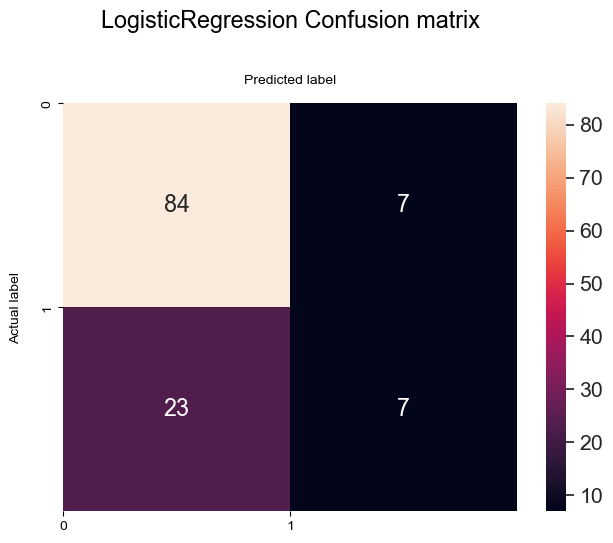

In [40]:
# Create the Confusion matrix
cm = confusion_matrix(y_test, predictions) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))

fig, ax = plt.subplots()
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')

class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('LogisticRegression Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')



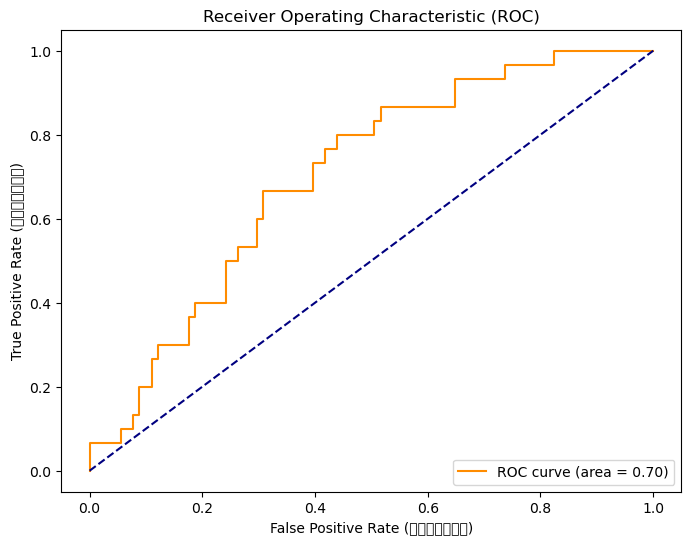

In [17]:
y_probs = model.predict_proba(X_test)[:, 1]

# 2. 計算 ROC 數值
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# 3. 繪圖
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # 隨機猜測線
plt.xlabel('False Positive Rate (冤枉好人的比例)')
plt.ylabel('True Positive Rate (抓到風險的比例)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

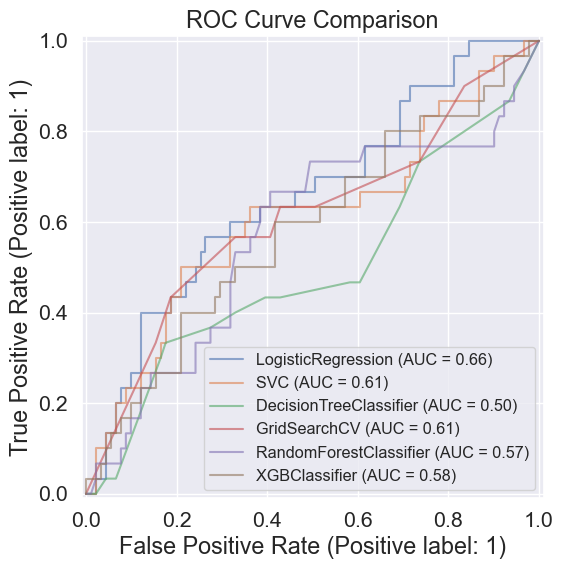

In [43]:
from sklearn.metrics import RocCurveDisplay
plt.figure(figsize=(8, 6))
ax = plt.gca()

log_disp = RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax, alpha=0.6)
svm_disp = RocCurveDisplay.from_estimator(model_svm, X_test_scaled, y_test, ax=ax, alpha=0.6)
model_dt_disp = RocCurveDisplay.from_estimator(model_dt, X_test_scaled, y_test, ax=ax, alpha=0.6)
grid_dt_disp = RocCurveDisplay.from_estimator(grid_dt, X_test_scaled, y_test, ax=ax, alpha=0.6)
model_rf_disp = RocCurveDisplay.from_estimator(model_rf, X_test_scaled, y_test, ax=ax, alpha=0.6)
model_xg_disp = RocCurveDisplay.from_estimator(model_xg, X_test_scaled, y_test, ax=ax, alpha=0.6)


plt.legend(fontsize='x-small', loc='lower right')
plt.title('ROC Curve Comparison')
plt.show()